# 3.2: 基于隐门奇异值分解的自动微分量子线路

问题：如何参数化任意二体、三体甚至 N 体量子门？

Automatically differentiable quantum circuits (ADQC)

* 考虑由M个量子门 {$\hat{G}^{(m)}$} $(m = 0, ..., M-1)$ 构成的变分量子线路

* 定义M个隐门（Latent Gate）{$\hat{V}^{(m)}$}，通过如下两步映射从隐门获得量子门：
  1. 奇异值分解：$V^{(m)} = P^{(m)}\Gamma^{(m)}Q^{(m)\dagger}$
  2. 矩阵乘法：$G^{(m)} = P^{(m)}Q^{(m)\dagger}$

性质：
1. 量子门须满足幺正约束，但是隐门及其对应的优化问题无约束；
2. 隐门与量子门间一一对应：奇异值分解的唯一性
3. 从隐门到量子门间的映射可微：奇异值分解是可微的
4. 当隐门自身满足幺正性时，$\Gamma^{(m)} = I$，$V^{(m)} = G^{(m)}$

> 初始化：
> 
> 当 $\Gamma$ 比较靠近 $I$ 时，这种初始化比较好；可以先得到 $P^{(m)}$ 和 $Q^{(m)}$ 然后在 $I$ 上加扰动

优势：不需要考虑量子门的种类以及具体的参数，只需要考虑量子门的个数和线路结构

## 例子

* 6 Qubits
* 10 个隐门
* 两层 Quantum Layer
  * 阶梯布局的结构
* 反向传播可以直接传播到隐门的参数上

![adqc-example](./images/adqc_example.png)

## Code

![adqc-code-example](./images/adqc_code_example.png)


In [ ]:
# |default_exp networks.adqc
# |export
import torch

In [1]:
from torch.optim import Adam
import matplotlib.pyplot as plt
from tensor_network.utils.tensors import zeros_state
from tensor_network.tensor_gates.functional import apply_gate
from tensor_network.utils.mapping import view_gate_tensor_as_matrix, view_gate_matrix_as_tensor

In [2]:
lr = 1e-3
iterations = 1500
num_qubits = 3
num_gates = 4
biqubit_gate_shape = (2, 2, 2, 2)

Iteration 0, Loss: 0.7232908606529236
Iteration 100, Loss: 0.3271958827972412
Iteration 200, Loss: 0.06101447343826294
Iteration 300, Loss: 0.005380153656005859
Iteration 400, Loss: 0.0004671812057495117
Iteration 500, Loss: 3.254413604736328e-05
Iteration 600, Loss: 1.8477439880371094e-06
Iteration 700, Loss: 0.0
Iteration 800, Loss: -3.5762786865234375e-07
Iteration 900, Loss: 1.7881393432617188e-07
Iteration 1000, Loss: 5.960464477539063e-08
Iteration 1100, Loss: 1.1920928955078125e-07
Iteration 1200, Loss: 1.1920928955078125e-07
Iteration 1300, Loss: -2.384185791015625e-07
Iteration 1400, Loss: 0.0


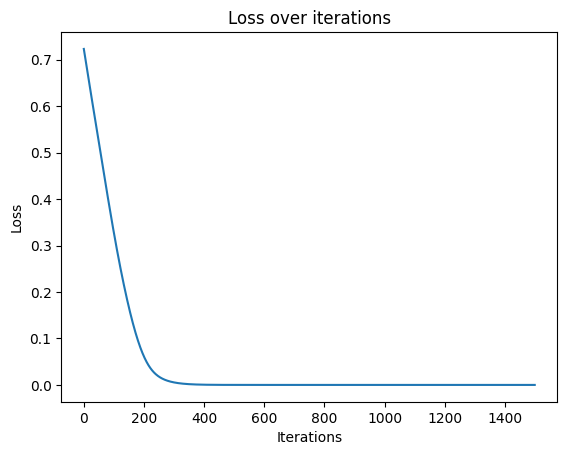

In [3]:
target_state = torch.randn(*([2] * num_qubits), dtype=torch.complex64)
target_state = target_state / target_state.norm()

latent_gates = [
    torch.randn(*biqubit_gate_shape, dtype=torch.complex64, requires_grad=True)
    for _ in range(num_gates)
]

optimizer = Adam(latent_gates, lr=lr)
losses = torch.empty(iterations, dtype=torch.float32)

for i in range(iterations):
    gates = []
    for latent_gate in latent_gates:
        P, _S, Q = torch.linalg.svd(view_gate_tensor_as_matrix(latent_gate, num_qubit=2))
        gate_matrix = P @ Q
        gate = view_gate_matrix_as_tensor(gate_matrix, num_qubit=2)
        gates.append(gate)

    state = zeros_state(num_qubits=num_qubits, dtype=torch.complex64)
    state = apply_gate(quantum_state=state, gate=gates[0], target_qubit=[0, 1])
    state = apply_gate(quantum_state=state, gate=gates[1], target_qubit=[1, 2])
    state = apply_gate(quantum_state=state, gate=gates[2], target_qubit=[0, 1])
    state = apply_gate(quantum_state=state, gate=gates[3], target_qubit=[1, 2])

    # loss = 1 - fidelity
    loss = 1 - (state.conj() * target_state).sum().norm()
    losses[i] = loss.detach()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {losses[i].item()}")

plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.show()